<a href="https://colab.research.google.com/github/pranshiii/Railway-Anomaly-Detection/blob/main/Railway_Track_Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dataset from Kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import os
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pragneshbarik","key":"f9acc8ebfa379a98564142560af8dfb9"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d salmaneunus/railway-track-fault-detection

100% 1.99G/2.00G [00:32<00:00, 94.0MB/s]
100% 2.00G/2.00G [00:32<00:00, 65.0MB/s]


In [ ]:
! unzip /content/railway-track-fault-detection.zip -d /content/

In [ ]:
os.rename('/content/Railway Track fault Detection Updated/', '/content/Railway')

# Code Section

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.metrics import classification_report

mpl.rcParams['figure.dpi'] = 100

# Image Visualization

In [ ]:


train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/Railway/Train',
  seed=123,
  image_size=image_size,
  batch_size=32)

Found 299 files belonging to 2 classes.


In [ ]:
image_size = (299, 299)

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

NameError: ignored

# Image Preprocessing and Augmentation

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    vertical_flip = True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)


val_data = val_datagen.flow_from_directory('/content/Railway/Validation', 
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='binary')

Found 62 images belonging to 2 classes.


In [ ]:
train_data = train_datagen.flow_from_directory('/content/Railway/Train', 
                                               target_size=image_size, 
                                               batch_size=32, 
                                               class_mode='binary')

val_data = val_datagen.flow_from_directory('/content/Railway/Validation', 
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='binary')

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


# Creating a Basic Convolutional Neural Network

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_size + (3, )))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(train_data,
        epochs=50,
        validation_data=val_data)

# Transfer Learing


In [ ]:
def url_to_model(model_url, image_size, hidden_layers, fine_tunable) :

  feature_vector = [hub.KerasLayer(model_url, trainable=fine_tunable)]
  sequential_list = feature_vector + hidden_layers
  
  model = tf.keras.Sequential(sequential_list)
  
  model.build([None, image_size[0], image_size[1], 3])
  
  model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

  return model

## **InceptionResnetV2**

Inception-ResNet-v2 is a convolutional neural architecture that builds on the Inception family of architectures but incorporates residual connections (replacing the filter concatenation stage of the Inception architecture).

[Read more](https://paperswithcode.com/method/inception-resnet-v2)
<br>
[PDF](https://arxiv.org/pdf/1602.07261v2.pdf)


![InceptionResnet](https://www.researchgate.net/profile/Masoud-Mahdianpari/publication/326421398/figure/fig9/AS:649354851385344@1531829669740/Schematic-diagram-of-InceptionResNetV2-model-compressed-view.png)

In [ ]:
inceptionResnet = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
                   trainable=False),  
    layers.Dense(1, activation='sigmoid')])

inceptionResnet.build([None, image_size[0], image_size[0], 3])

KeyboardInterrupt: ignored

In [ ]:
inceptionResnet.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

inceptionResnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1536)              54336736  
                                                                 
 dense_5 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
hidden_layers = [
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
]

In [ ]:
url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"
inceptionResnetV2 = url_to_model(url, (299, 299), hidden_layers, False)

In [ ]:
inceptionResnetV2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              54336736  
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 54,437,217
Trainable params: 100,481
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
history = inceptionResnetV2.fit(train_data, validation_data=val_data, epochs=50)

Epoch 1/50
10/10 [==============================] - 107s 9s/step - loss: 0.6929 - accuracy: 0.5485 - val_loss: 0.6208 - val_accuracy: 0.6935
Epoch 2/50
10/10 [==============================] - 77s 8s/step - loss: 0.5937 - accuracy: 0.7023 - val_loss: 0.6049 - val_accuracy: 0.5806
Epoch 3/50
10/10 [==============================] - 78s 8s/step - loss: 0.5674 - accuracy: 0.6923 - val_loss: 0.7286 - val_accuracy: 0.5968
Epoch 4/50
10/10 [==============================] - 76s 8s/step - loss: 0.5294 - accuracy: 0.6890 - val_loss: 0.6070 - val_accuracy: 0.6290
Epoch 5/50
10/10 [==============================] - 74s 7s/step - loss: 0.5146 - accuracy: 0.7893 - val_loss: 0.5259 - val_accuracy: 0.7258
Epoch 6/50
10/10 [==============================] - 75s 8s/step - loss: 0.4918 - accuracy: 0.7659 - val_loss: 0.5967 - val_accuracy: 0.6290
Epoch 7/50
10/10 [==============================] - 75s 8s/step - loss: 0.5169 - accuracy: 0.7291 - val_loss: 0.5233 - val_accuracy: 0.6774
Epoch 8/50
10/10 [=

In [ ]:
import joblib
joblib.dump(history.history, '/content/historyIncRes.sav')

['/content/historyIncRes.sav']

### Model History

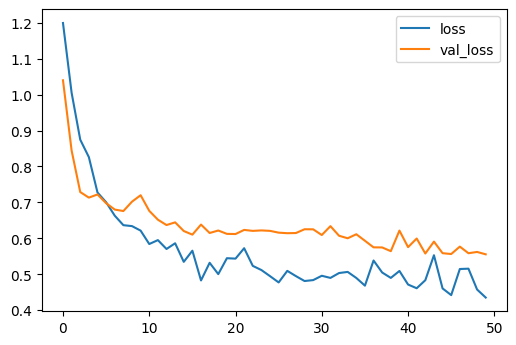

In [ ]:
x_epochs = np.arange(50)
plt.plot(x_epochs, inceptionResnet.history.history['loss'], label='loss')
plt.plot(x_epochs, inceptionResnet.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

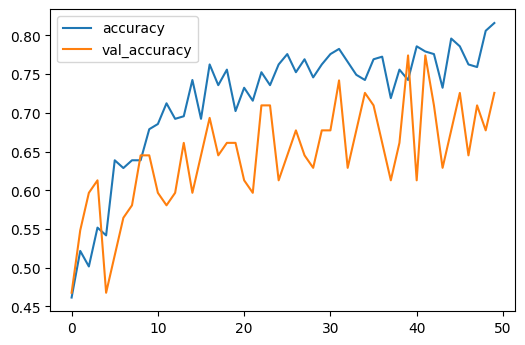

In [ ]:
plt.plot(x_epochs, inceptionResnet.history.history['accuracy'], label='accuracy')
plt.plot(x_epochs, inceptionResnet.history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)


test_data = test_datagen.flow_from_directory('/content/Railway/Train', 
                                            target_size=(100, 150),
                                            batch_size=32,
                                            class_mode='binary')

Found 299 images belonging to 2 classes.


### Model Evaluation

In [ ]:
inceptionResnet.evaluate(test_data)

10/10 [==============================] - 79s 8s/step - loss: 0.4945 - accuracy: 0.7759


[0.49450740218162537, 0.7759197354316711]

### Classification Report

## MobileNetV3

MobileNetV3 is a convolutional neural network that is tuned to mobile phone CPUs.

[Read more](https://paperswithcode.com/method/mobilenetv3)<br>
[PDF](https://arxiv.org/pdf/1905.02244v5.pdf)

![MobileNet](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-21_at_11.03.15_PM.png)

In [ ]:
mobileNet = url_to_model("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5", 
                        image_size,
                        hidden_layers, 
                        False
                        )

In [ ]:
mobileNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              4226432   
                                                                 
 dense_3 (Dense)             (None, 800)               1024800   
                                                                 
 dense_4 (Dense)             (None, 100)               80100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,331,433
Trainable params: 1,105,001
Non-trainable params: 4,226,432
_________________________________________________________________


In [ ]:
mobileNetHistory = mobileNet.fit(train_data, validation_data=val_data, epochs=50)

Epoch 1/50
10/10 [==============================] - 96s 8s/step - loss: 0.8137 - accuracy: 0.5987 - val_loss: 0.5820 - val_accuracy: 0.6613
Epoch 2/50
10/10 [==============================] - 81s 9s/step - loss: 0.4695 - accuracy: 0.7826 - val_loss: 0.4442 - val_accuracy: 0.7581
Epoch 3/50
10/10 [==============================] - 78s 8s/step - loss: 0.3792 - accuracy: 0.8060 - val_loss: 0.4979 - val_accuracy: 0.7581
Epoch 4/50
10/10 [==============================] - 84s 9s/step - loss: 0.4161 - accuracy: 0.8027 - val_loss: 0.4341 - val_accuracy: 0.7419
Epoch 5/50
10/10 [==============================] - 80s 8s/step - loss: 0.3350 - accuracy: 0.8361 - val_loss: 0.4114 - val_accuracy: 0.7742
Epoch 6/50
10/10 [==============================] - 77s 8s/step - loss: 0.3123 - accuracy: 0.8662 - val_loss: 0.4572 - val_accuracy: 0.7742
Epoch 7/50
10/10 [==============================] - 77s 8s/step - loss: 0.2940 - accuracy: 0.8796 - val_loss: 0.4944 - val_accuracy: 0.7581
Epoch 8/50
10/10 [==

In [ ]:
mobileNet.save('/content/drive/MyDrive/models/MobileNet')

### Model History

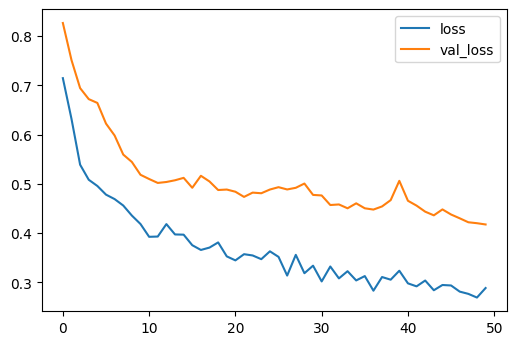

In [ ]:
plt.plot(x_epochs, mobileNetHistory.history['loss'], label='loss')
plt.plot(x_epochs, mobileNetHistory.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

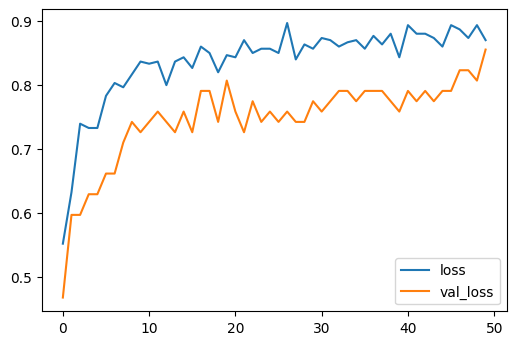

In [ ]:
plt.plot(x_epochs, mobileNetHistory.history['accuracy'], label='loss')
plt.plot(x_epochs, mobileNetHistory.history['val_accuracy'], label='val_loss')
plt.legend()
plt.show()

### Model Evaluation

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)


test_data = test_datagen.flow_from_directory('/content/Railway/Train', 
                                            target_size=image_size,
                                            batch_size=1,
                                            class_mode='binary')

Found 299 images belonging to 2 classes.


### Classification Report

In [ ]:
# /content/drive/MyDrive/models/MobileNetV1/epoch_45
import tensorflow as tf
mobileNetV1 = tf.keras.models.load_model('/content/drive/MyDrive/models/MobileNetV1/epoch_45')

In [ ]:
mobileNetV1

AttributeError: ignored

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/models/MobileNetV1/epoch_45')
tflite_model = converter.convert()

In [ ]:
with open('/content/drive/MyDrive/MobileNetLite/model.tflite', 'wb') as f:
  f.write(tflite_model)